In [1]:
%%capture
pip install torchvision

In [2]:
import pennylane as qml
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import Subset
import numpy as np
import matplotlib.pyplot as plt

## MNIST

In [3]:
transform = transforms.Compose([
    transforms.Resize((16, 16)),
    transforms.ToTensor()
])

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_indices = [i for i, (x, y) in enumerate(mnist_trainset) if y in [0, 1]]
test_indices = [i for i, (x, y) in enumerate(mnist_testset) if y in [0, 1]]

train_size = 10000
test_size = 2000

train_indices = train_indices[:train_size]
test_indices = test_indices[:test_size]

mnist_trainset_small = Subset(mnist_trainset, train_indices)
mnist_testset_small = Subset(mnist_testset, test_indices)


import torch
X_train = torch.stack([item[0] for item in mnist_trainset_small])
y_train = torch.tensor([item[1] for item in mnist_trainset_small])
X_train = X_train.reshape(10000,16,16,1)
X_test = torch.stack([item[0] for item in mnist_testset_small])
y_test = torch.tensor([item[1] for item in mnist_testset_small])
X_test = X_test.reshape(2000,16,16,1)
X_train.shape, X_test.shape

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 46876876.59it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 3298543.02it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 11733304.71it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 2269541.19it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



(torch.Size([10000, 16, 16, 1]), torch.Size([2000, 16, 16, 1]))

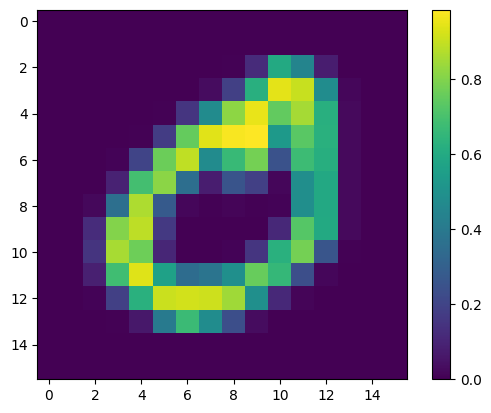

tensor(0)


In [4]:
n = 5
plt.imshow(X_train[n])
plt.colorbar()
plt.show()
print(y_train[n])

## model: FC + QC + FC + SOFTMAX


/usr/local/lib/python3.10/dist-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


(<Figure size 5800x900 with 1 Axes>, <Axes: >)

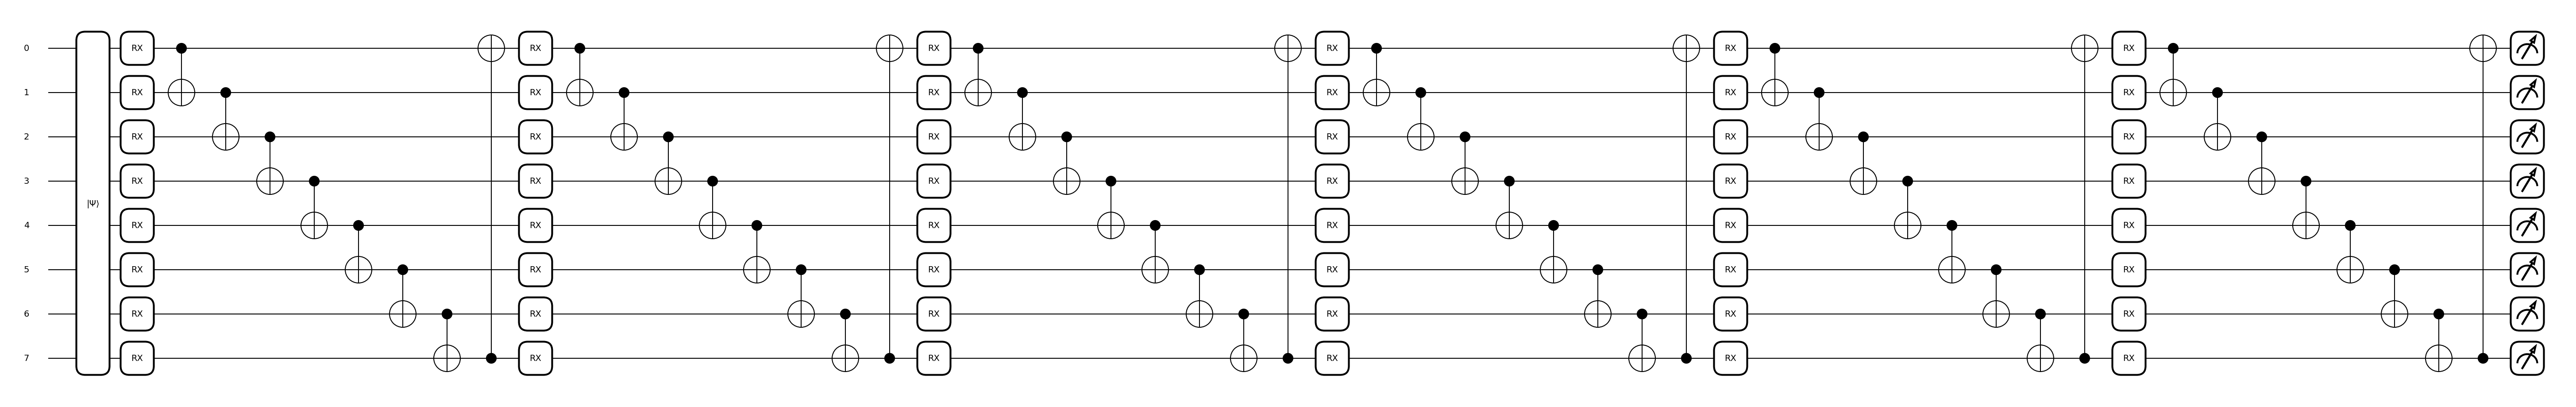

In [5]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    #image = inputs.reshape(16*16)
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

qml.draw_mpl(qnode, expansion_strategy="device")(X_train[0].reshape(16*16), weights= np.random.rand(n_layers, n_qubits))

In [6]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) # 48 params

clayer_1 = torch.nn.Linear(256, 256) # 4 weights, 2 bias
clayer_2 = torch.nn.Linear(8, 2) # 4 w, 2 b
softmax = torch.nn.Softmax(dim=1) # no params

layers = [clayer_1, qlayer, clayer_2, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [7]:
# print total number of params
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

# print number of params per layer
print(model[1].parameters())  # Pesos de la primera capa

Total trainable parameters: 65858
<generator object Module.parameters at 0x7cbafc0e3140>


In [8]:
model(X_train[0].reshape(1,256))

tensor([[0.5095, 0.4905]], grad_fn=<SoftmaxBackward0>)

In [9]:
import torch
import torch.nn.functional as F


# one-hot encoding
num_classes = 2
y_train_one_hot = F.one_hot(y_train, num_classes=num_classes)

X = X_train.reshape(10000, 16*16).float().requires_grad_(True)
y_hot = y_train_one_hot.long()


batch_size = 64
batches = 10000 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 5

for epoch in range(epochs):
    running_loss = 0
    for xs, ys in data_loader:
        opt.zero_grad()
        y_pred = model(xs)
        loss_evaluated = loss(y_pred, ys)
        loss_evaluated.backward()
        opt.step()
        running_loss += loss_evaluated.item()
    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))

y_pred = model(X)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_train.numpy()).sum()
accuracy = correct / len(y_train)
print(f"Accuracy: {accuracy * 100}%")


Average loss over epoch 1: 0.1359
Average loss over epoch 2: 0.0170
Average loss over epoch 3: 0.0098
Average loss over epoch 4: 0.0071
Average loss over epoch 5: 0.0057
Accuracy: 99.79%


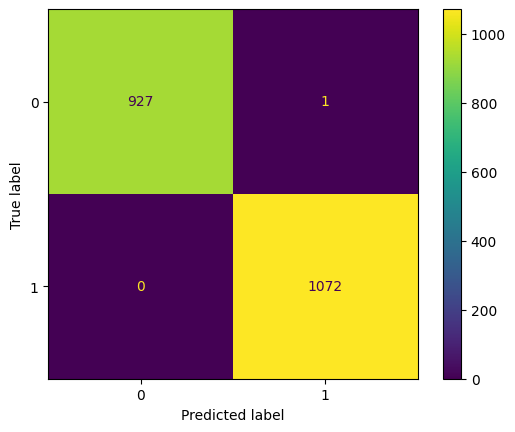

In [10]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = X_test.reshape(2000, 16*16).float().requires_grad_(True)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

## model: QC + FC + SOFTMAX


In [11]:
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def qnode(inputs, weights):
    qml.AmplitudeEmbedding(inputs, wires=range(n_qubits), normalize=True)
    qml.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 6
weight_shapes = {"weights": (n_layers, n_qubits)}

print(qml.draw(qnode, expansion_strategy="device")(X_train[0].reshape(16*16), weights= np.random.rand(n_layers, n_qubits)))

0: ─╭|Ψ⟩──RX(0.90)─╭●───────────────────╭X──RX(0.71)─╭●───────────────────╭X──RX(0.83)─╭●─────────
1: ─├|Ψ⟩──RX(0.71)─╰X─╭●────────────────│───RX(0.39)─╰X─╭●────────────────│───RX(0.61)─╰X─╭●──────
2: ─├|Ψ⟩──RX(0.18)────╰X─╭●─────────────│───RX(0.95)────╰X─╭●─────────────│───RX(0.85)────╰X─╭●───
3: ─├|Ψ⟩──RX(0.57)───────╰X─╭●──────────│───RX(0.53)───────╰X─╭●──────────│───RX(0.16)───────╰X─╭●
4: ─├|Ψ⟩──RX(0.07)──────────╰X─╭●───────│───RX(0.63)──────────╰X─╭●───────│───RX(0.75)──────────╰X
5: ─├|Ψ⟩──RX(0.01)─────────────╰X─╭●────│───RX(0.83)─────────────╰X─╭●────│───RX(0.48)────────────
6: ─├|Ψ⟩──RX(0.43)────────────────╰X─╭●─│───RX(0.48)────────────────╰X─╭●─│───RX(0.06)────────────
7: ─╰|Ψ⟩──RX(0.12)───────────────────╰X─╰●──RX(0.62)───────────────────╰X─╰●──RX(0.30)────────────

───────────╭X──RX(0.44)─╭●───────────────────╭X──RX(0.30)─╭●───────────────────╭X──RX(0.23)─╭●──────
───────────│───RX(0.76)─╰X─╭●────────────────│───RX(0.73)─╰X─╭●────────────────│───RX(0.83)─╰X─╭●───
─────

/usr/local/lib/python3.10/dist-packages/pennylane/drawer/draw.py:37: PennyLaneDeprecationWarning: The 'expansion_strategy' argument is deprecated and will be removed in version 0.39. Instead, use the 'level' argument which offers more flexibility and options.
  warnings.warn(


In [12]:
qlayer = qml.qnn.TorchLayer(qnode, weight_shapes) 

clayer_1 = torch.nn.Linear(8, 2) 
softmax = torch.nn.Softmax(dim=1) 

layers = [qlayer, clayer_1, softmax]
model = torch.nn.Sequential(*layers)

opt = torch.optim.SGD(model.parameters(), lr=0.1)
loss = torch.nn.L1Loss()

In [13]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 66


In [14]:
import torch
import torch.nn.functional as F

num_classes = 2
y_train = F.one_hot(y_train, num_classes=num_classes)

X = X_train.reshape(10000, 16*16).float().requires_grad_(True)
y_train = y_train.long()


batch_size = 64
batches = 10000 // batch_size

data_loader = torch.utils.data.DataLoader(
    list(zip(X, y_hot)), batch_size=batch_size, shuffle=True, drop_last=True
)

epochs = 5

for epoch in range(epochs):
    running_loss = 0

    for xs, ys in data_loader:
        opt.zero_grad()

        y_pred = model(xs)

        loss_evaluated = loss(y_pred, ys)

        loss_evaluated.backward()
        opt.step()

        running_loss += loss_evaluated.item()

    avg_loss = running_loss / batches
    print("Average loss over epoch {}: {:.4f}".format(epoch + 1, avg_loss))



Average loss over epoch 1: 0.4201
Average loss over epoch 2: 0.2607
Average loss over epoch 3: 0.1738
Average loss over epoch 4: 0.1348
Average loss over epoch 5: 0.1131


In [68]:
import torch
import torch.nn.functional as F

y_train_one_hot = F.one_hot(y_train, num_classes=num_classes)

y_pred = model(X_train.reshape(10000, 16*16).float())

_, y_pred_classes = torch.max(y_pred, dim=1)

y_pred_classes = F.one_hot(y_pred_classes, num_classes=num_classes)

y_train_classes = torch.argmax(y_train_one_hot, dim=1)

correct = (y_pred_classes == y_train_classes).sum()

accuracy = correct / len(y_train_classes)

In [70]:
print(f"Accuracy: {accuracy/2}%")

Accuracy: 0.9732000231742859%


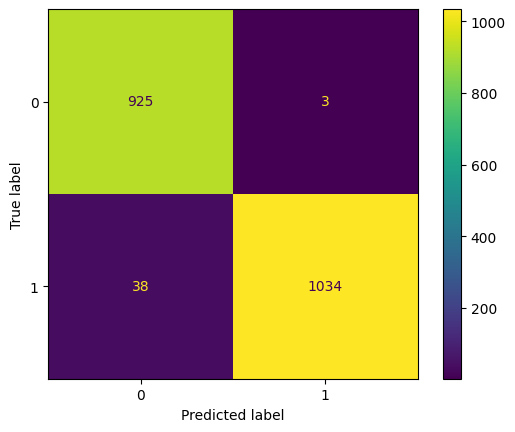

In [71]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_test = X_test.reshape(2000, 16*16).float().requires_grad_(True)

y_pred = model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()